In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

import warnings
import re
import pandas as pd

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## <b> Leitura da Base

In [4]:
def split_focal(row):
    focals = row['Focal'].split(' | ')
    new_rows = []
    for focal in focals:
        new_row = row.copy()
        new_row['Focal'] = focal
        new_rows.append(new_row)
    return new_rows

df = pd.read_excel('Base - FeedBacks Clientes.xlsx')
list_of_new_rows = df.apply(split_focal, axis=1).tolist()
new_rows = [row for rows in list_of_new_rows for row in rows]
df = pd.DataFrame(new_rows)

df['Focal'].replace('Gestão de terceiros', 'Gestão de Terceiros', inplace=True)
df['Focal'].replace('comercial','Comercial', inplace=True)

df = df[['Mapeamento_Final', 'Focal']]
df

,Mapeamento_Final,Focal
0,"Foi uma ligação de deste entre a operadora e possivelmente alguém responsável por realizar reparos no sistema, pois se cumprimentam ligação fica muda e após confirmar que foi autorizado ambos desligam",Não necessário
1,Foi uma ligação de teste,Não necessário
2,"Correspondente informa que começou a menos de semanas a trabalhar com expresso e que já recebeu todo o maquinário e ao ser questionado se já entraram em contato para fazer o treinamento correspondente só informam que ligaram há algum tempo fazendo as mesmas perguntas, mas não confirmou se já fez o treinamento, mas confirmou está tudo bem e que se sente segura a fazer as transações finaliza informando que estava ocupada e qualquer dúvida perguntará ao gerente",Não necessário
3,"Correspondente informa que não está transacionando, pois não tem internet há mais de uma semana por problema na operadora dele, mas tem vontade de voltar transacionar correspondente solicita uma máquina mais moderna",Gestão de Terceiros
4,"Correspondente informa que já foi instalado a máquina e já recebeu o treinamento informa que não tem dúvidas e que em tudo que precisa o sistema já está o atendendo correspondente informa que ainda não se cadastrou no site do expresso correspondente não tinha o telefone do gerente, mas anotou o e-mail do canal de atendimento correspondente informa que no momento está apenas fazendo deposito e pagamentos, mas irá ativar demais funcionalidades aos poucos",Não necessário
...,...,...
1422,"Informou que como faz pouco tempo que está como correspondente está concentrando as operações somente com ele, porém ele se ausentou, pois fez uma cirurgia, mas já está retornando aos poucos",Não necessário
1423,"Correspondente disse que a implantação foi um sucesso teve uma dúvida quanto o saque, mas passei o número do coordenador para ele poder sanar as dúvidas",Não necessário
1424,"A implantação da maquininha foi finalizada, mas ainda não trabalha com negócios disse que combinou com a gerente de apresentar e ver se vai colocar na loja",Não necessário
1425,"Informou que a implantação foi finalizada, mas de acordo com ela não é viável manter, pois demanda muito tempo que ela não tem já conversou com o gerente e o material está aguardando esperado o contato dos responsáveis trocar",Comercial


### <B> Distribuição das Categorias

In [5]:
df['Focal'].value_counts()

Focal
Não necessário         731
Comercial              337
Gestão de Terceiros    220
Implantação            119
Estratégia              50
Marketing               26
Name: count, dtype: int64

### <B> Pré-Processamento

In [6]:
# Função unificada para pré-processamento (remoção de pontuação, tokenização e stemming)
def preprocess(text):
    rs = RSLPStemmer()  # Stemmer para português
    stop_words = set(stopwords.words('portuguese'))  # Stopwords para português

    text = re.sub(r'[^\w\s]', '', text)     # Remove pontuação
    text = text.lower()    # Converte o texto para minúsculas
    words = word_tokenize(text)    # Tokeniza o texto
    words = [word for word in words if word not in stop_words]    # Remove stopwords
    words = [rs.stem(word) for word in words]    # Aplica o stemming (extrai o radical das palavras)
    
    return words  # Retorna a lista de palavras processadas

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Vetorização usando TF-IDF e extração dos radicais das palavras
def vectorize_text(train_data, test_data):
    vectorizer = TfidfVectorizer(tokenizer=preprocess)
    train_features = vectorizer.fit_transform(train_data)
    test_features = vectorizer.transform(test_data)
    return train_features, test_features, vectorizer

# Função de classificação usando TF-IDF e Similaridade Cosseno
def classify_with_tfidf_cosine(train_data, test_data, train_labels):
    # Vetorizar os textos de treino e teste usando TF-IDF
    train_features, test_features, vectorizer = vectorize_text(train_data, test_data)
    
    # Lista para armazenar as categorias previstas
    predicted_categories = []

    # Itera sobre cada texto no conjunto de teste
    for i in range(test_features.shape[0]):
        cosine_similarities = cosine_similarity(test_features[i], train_features).flatten()  # Calcula a similaridade cosseno entre o texto de teste atual e todos os textos de treino
        most_similar_idx = cosine_similarities.argmax()         # Encontra o índice do texto de treino mais similar (maior similaridade cosseno)
        predicted_categories.append(train_labels.iloc[most_similar_idx])         # Armazena a categoria da instância de treino mais similar

    return predicted_categories


### <B> Estruturação da Similaridade Cosseno e Aplicação


Contagem de rótulos reais: Counter({'Não necessário': 172, 'Comercial': 49, 'Gestão de Terceiros': 36, 'Implantação': 30, 'Estratégia': 5, 'Marketing': 5})
Contagem de rótulos previstos: Counter({'Não necessário': 179, 'Gestão de Terceiros': 58, 'Comercial': 33, 'Implantação': 21, 'Estratégia': 6})

--- Avaliação Geral do Modelo ---
Acurácia: 0.6128
Precisão (Ponderada): 0.6067
Revocação (Ponderada): 0.6128
F1-score (Ponderado): 0.6024

--- Especificidade por Classe ---
Classe Não necessário: Especificidade = 0.6240
Classe Gestão de Terceiros: Especificidade = 0.8621
Classe Comercial: Especificidade = 0.9315
Classe Marketing: Especificidade = 1.0000
Classe Implantação: Especificidade = 0.9588
Classe Estratégia: Especificidade = 0.9863


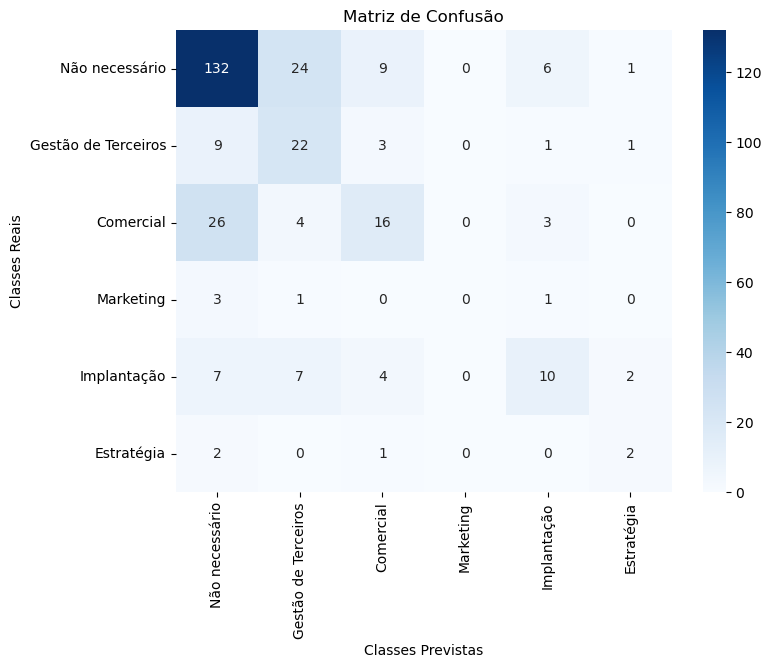

In [7]:

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Função para avaliar a performance do modelo e plotar a matriz de confusão
def evaluate_classification(true_labels, predicted_labels, class_labels):
    # Imprimindo a distribuição de rótulos reais e previstos para verificar discrepâncias
    print("\nContagem de rótulos reais:", Counter(true_labels))
    print("Contagem de rótulos previstos:", Counter(predicted_labels))

    # Calcula a acurácia
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calcula a precisão ponderada
    precision = precision_score(true_labels, predicted_labels, average='weighted')

    # Calcula a revocação ponderada
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    # Calcula o F1-score ponderado
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calcula a matriz de confusão
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

    # Calcula a especificidade (usando a matriz de confusão)
    # Especificidade: para cada classe, calcula (VN / (VN + FP))
    specificity_per_class = []
    for i in range(conf_matrix.shape[0]):
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

    # Exibe os resultados gerais
    print(f"\n--- Avaliação Geral do Modelo ---")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão (Ponderada): {precision:.4f}")
    print(f"Revocação (Ponderada): {recall:.4f}")
    print(f"F1-score (Ponderado): {f1:.4f}")

    # Exibe a especificidade por classe
    print(f"\n--- Especificidade por Classe ---")
    for idx, specificity in enumerate(specificity_per_class):
        print(f"Classe {class_labels[idx]}: Especificidade = {specificity:.4f}")

    # Plotando a matriz de confusão com valores absolutos
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Matriz de Confusão')
    plt.xlabel('Classes Previstas')
    plt.ylabel('Classes Reais')
    plt.show()

# Exemplo de uso (ajustado para seus dados e rótulos)
class_labels = ['Não necessário', 'Comercial', 'Gestão de Terceiros', 'Implantação', 'Estratégia', 'Marketing']

# Dividimos o conjunto de dados em treino e teste (80% treino, 20% teste)
train_data = df['Mapeamento_Final'][:int(0.8*len(df))]
test_data = df['Mapeamento_Final'][int(0.8*len(df)):]
train_labels = df['Focal'][:int(0.8*len(df))]
test_labels = df['Focal'][int(0.8*len(df)):]

# Classificação usando Similaridade Cosseno
predicted_labels = classify_with_tfidf_cosine(train_data, test_data, train_labels)

# Nomes das classes
class_labels = train_labels.unique()

# Avaliação do desempenho e exibição da matriz de confusão
evaluate_classification(test_labels, predicted_labels, class_labels)
